/home.ufs/yw4236/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home.ufs/yw4236/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


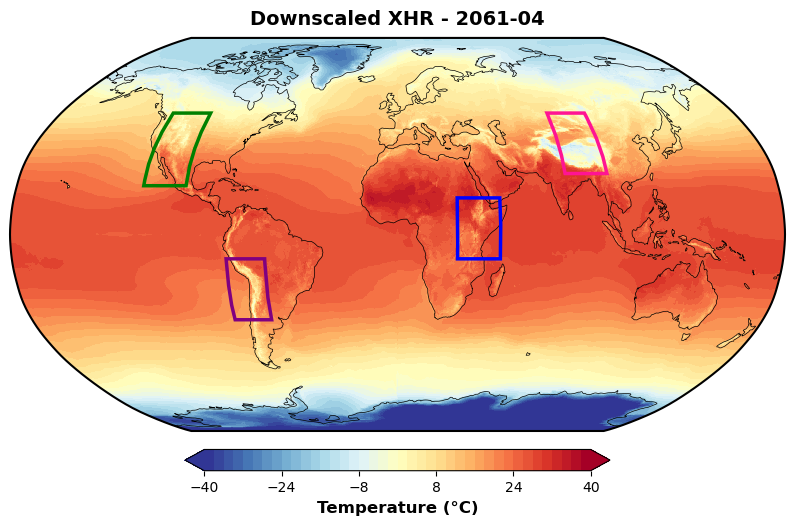

Saved: Figures/XHR/downscaled.png

All figures saved!


In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from pathlib import Path
from matplotlib.colors import BoundaryNorm
from matplotlib.patches import Rectangle

# Load data
results = xr.open_dataset("evaluation_results_xhr/g6sulfur_downscaled_xhr.nc")
g6_lr = xr.open_dataset("data/cmip6/g6sulfur_lr_tas_monthly_2015_2100.nc")
g6_detrend = xr.open_dataset("data/cmip6/g6_test_detrend_xhr.nc")['__xarray_dataarray_variable__']

# Create output directory
output_dir = Path("Figures/XHR")
output_dir.mkdir(parents=True, exist_ok=True)

# Time index
t = 555

# Get time string for title (Year-Month)
time_val = results['time'].isel(time=t).values
time_str = str(time_val)[:7]

# Extract data: single time index, convert K to °C
data_dict = {
    'lr': g6_lr['tas'].isel(time=t).values - 273.15,
    'interp': results['tas_cmip6_interp'].isel(time=t).values - 273.15,
    'residual': results['tas_residual_pred'].isel(time=t).values,
    'downscaled': results['tas_downscaled'].isel(time=t).values - 273.15,
    'detrend': g6_detrend.isel(time=t).values
}

# Get coordinates
lat = results['lat'].values
lon = results['lon'].values
lat_lr = g6_lr['lat'].values
lon_lr = g6_lr['lon'].values
lat_detrend = g6_detrend['lat'].values
lon_detrend = g6_detrend['lon'].values

# Manual vmin/vmax
vmin, vmax = -40, 40
vmin_res, vmax_res = -10, 10
vmin_detrend, vmax_detrend = -10, 10

# Create discrete norms
bounds_temp = np.linspace(vmin, vmax, 41)
bounds_res = np.linspace(vmin_res, vmax_res, 41)
bounds_detrend = np.linspace(vmin_detrend, vmax_detrend, 41)

cmap = plt.cm.RdYlBu_r
norm_temp = BoundaryNorm(bounds_temp, cmap.N)
norm_res = BoundaryNorm(bounds_res, cmap.N)
norm_detrend = BoundaryNorm(bounds_detrend, cmap.N)

# Region boxes: name, [lon_min, lon_max, lat_min, lat_max], color
regions = [
    ('north_america', [-120, -100, 20, 50], 'green'),    
    ('south_america', [-80, -62, -35, -10], 'purple'),     
    ('asia', [80, 100, 25, 50], 'deeppink'),               
    ('africa', [28, 48, -10, 15], 'blue'),                 
]

def add_region_boxes(ax, regions):
    """Add rectangular boxes for each region"""
    for name, extent, color in regions:
        lon_min, lon_max, lat_min, lat_max = extent
        width = lon_max - lon_min
        height = lat_max - lat_min
        rect = Rectangle((lon_min, lat_min), width, height,
                         linewidth=2.5, edgecolor=color, facecolor='none',
                         transform=ccrs.PlateCarree(), zorder=10)
        ax.add_patch(rect)

# Plotting function
def plot_robinson(data, lat, lon, filename, norm, bounds, cbar_label='', title='', add_boxes=False):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
    
    lon_2d, lat_2d = np.meshgrid(lon, lat)
    
    im = ax.pcolormesh(lon_2d, lat_2d, data,
                       transform=ccrs.PlateCarree(),
                       cmap=cmap, norm=norm,
                       shading='auto')
    
    ax.coastlines(linewidth=0.5)
    ax.set_global()
    
    # Add region boxes if requested
    if add_boxes:
        add_region_boxes(ax, regions)
    
    ax.spines['geo'].set_edgecolor('black')
    ax.spines['geo'].set_linewidth(1.5)
    ax.set_title(title, fontsize=14, fontweight='bold', pad=10)
    
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', 
                        fraction=0.046, pad=0.04, shrink=0.6,
                        ticks=bounds[::8], extend='both')
    cbar.set_label(cbar_label, fontsize=12, fontweight='bold')
    cbar.ax.tick_params(labelsize=10)
    
    plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    print(f"Saved: {filename}")

# Plot each field
plot_robinson(data_dict['lr'], lat_lr, lon_lr, 
              output_dir / "lr.png", norm_temp, bounds_temp,
              cbar_label='Temperature (°C)', title=f'LR G6sulfur - {time_str}')

plot_robinson(data_dict['interp'], lat, lon, 
              output_dir / "interp.png", norm_temp, bounds_temp,
              cbar_label='Temperature (°C)', title=f'Interpolated LR - {time_str}')

plot_robinson(data_dict['detrend'], lat_detrend, lon_detrend, 
              output_dir / "detrend.png", norm_detrend, bounds_detrend,
              cbar_label='Temperature (°C)', title=f'Detrended LR - {time_str}')

plot_robinson(data_dict['residual'], lat, lon, 
              output_dir / "residual.png", norm_res, bounds_res,
              cbar_label='Temperature (°C)', title=f'Predicted Residual - {time_str}')

# XHR downscaled with region boxes
plot_robinson(data_dict['downscaled'], lat, lon, 
              output_dir / "downscaled.png", norm_temp, bounds_temp,
              cbar_label='Temperature (°C)', title=f'Downscaled XHR - {time_str}',
              add_boxes=True)

print("\nAll figures saved!")

/home.ufs/yw4236/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home.ufs/yw4236/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


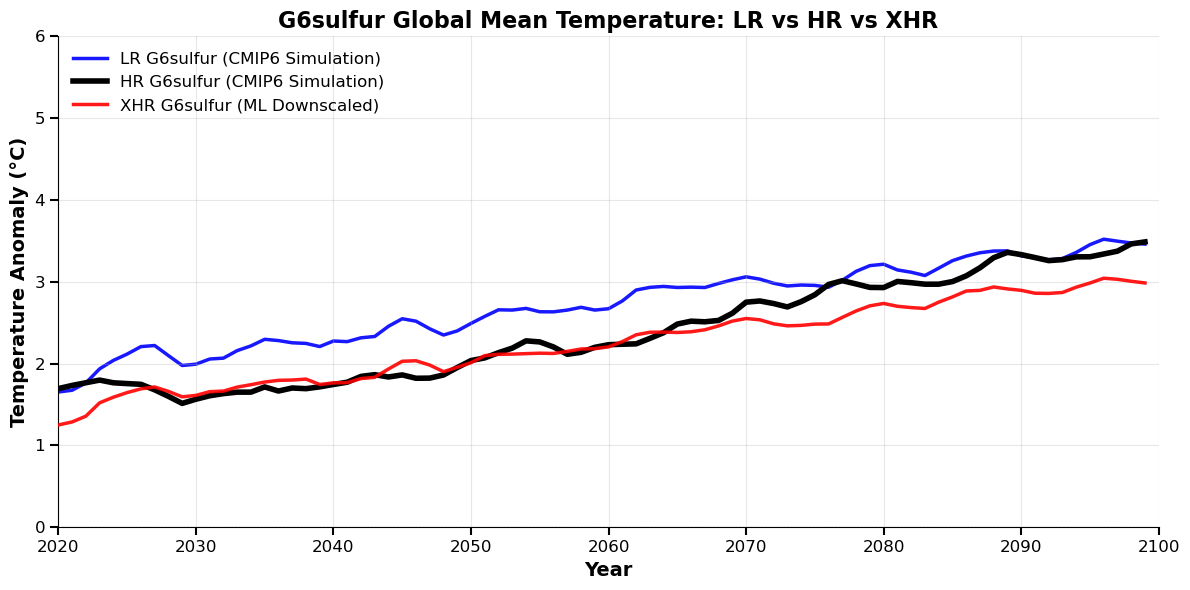

Figure saved!


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import pandas as pd

# Configuration
figures_dir = Path("Figures/XHR")
figures_dir.mkdir(parents=True, exist_ok=True)

# Load data
hr_file = Path("evaluation_results/tas_evaluation_g6sulfur.nc")
ds_hr = xr.open_dataset(hr_file)

xhr_file = Path("evaluation_results_xhr/g6sulfur_downscaled_xhr.nc")
ds_xhr = xr.open_dataset(xhr_file)

lr_file = Path("data/cmip6/g6sulfur_lr_tas_monthly_2015_2100.nc")
ds_lr = xr.open_dataset(lr_file)

hist_file = Path("data/MPI-ESM1-2-HR-LR_historical_r1i1p1f1_1850_2014_allvars.nc")
ds_hist = xr.open_dataset(hist_file)

def calc_baseline(ds, var='tas_hr', start_year=1850, end_year=1900):
    """Calculate baseline mean for reference period"""
    data = ds[var]
    years = ds.time.dt.year
    mask = (years >= start_year) & (years <= end_year)
    baseline_data = data.isel(time=mask)
    baseline = baseline_data.mean(dim=['time', 'lat', 'lon'])
    return float(baseline.values)

def calc_global_mean(data):
    """Calculate simple global mean"""
    return np.mean(data, axis=(1, 2))

def to_annual_mean(data, time_coords):
    """Convert to annual averages"""
    years = time_coords.dt.year.values
    df = pd.DataFrame({'year': years, 'value': data})
    annual = df.groupby('year')['value'].mean()
    return annual.index.values, annual.values

def smooth_data(data, window=3):
    """Apply rolling mean to annual data"""
    df = pd.Series(data)
    smoothed = df.rolling(window=window, center=True, min_periods=1).mean()
    return smoothed.values

# Calculate baseline (in °C)
baseline = calc_baseline(ds_hist, 'tas_hr', 1850, 1900)

# Process HR G6sulfur
time_slice = slice('2020', '2099')
hr_data = ds_hr['groundtruth'].sel(time=time_slice).values
hr_time = ds_hr['groundtruth'].sel(time=time_slice).time
hr_mean = calc_global_mean(hr_data) - baseline
years_hr, hr_annual = to_annual_mean(hr_mean, hr_time)
hr_smooth = smooth_data(hr_annual, window=3)

# Process XHR G6sulfur (convert K to °C)
xhr_data = ds_xhr['tas_downscaled'].sel(time=time_slice).values - 273.15
xhr_time = ds_xhr['tas_downscaled'].sel(time=time_slice).time
xhr_mean = calc_global_mean(xhr_data) - baseline
years_xhr, xhr_annual = to_annual_mean(xhr_mean, xhr_time)
xhr_smooth = smooth_data(xhr_annual, window=3)

# Process LR G6sulfur (convert K to °C)
lr_data = ds_lr['tas'].sel(time=time_slice).values - 273.15
lr_time = ds_lr['tas'].sel(time=time_slice).time
lr_mean = calc_global_mean(lr_data) - baseline
years_lr, lr_annual = to_annual_mean(lr_mean, lr_time)
lr_smooth = smooth_data(lr_annual, window=3)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(years_lr, lr_smooth, 
        color='blue', linestyle='-', linewidth=2.5,
        label='LR G6sulfur (CMIP6 Simulation)', alpha=0.9, zorder=1)

ax.plot(years_hr, hr_smooth, 
        color='black', linestyle='-', linewidth=4,
        label='HR G6sulfur (CMIP6 Simulation)', zorder=2)

ax.plot(years_xhr, xhr_smooth, 
        color='red', linestyle='-', linewidth=2.5,
        label='XHR G6sulfur (ML Downscaled)', alpha=0.9, zorder=3)

# Format
ax.axhline(y=0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
ax.set_ylim(0, 6)
ax.set_yticks(np.arange(0, 7, 1))
ax.set_xlim(2020, 2100)
ax.set_xlabel('Year', fontsize=14, fontweight='bold')
ax.set_ylabel('Temperature Anomaly (°C)', fontsize=14, fontweight='bold')
ax.set_title('G6sulfur Global Mean Temperature: LR vs HR vs XHR', fontsize=16, fontweight='bold')
ax.legend(loc='upper left', fontsize=12, frameon=False)
ax.grid(True, alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(labelsize=12, length=6, width=1.5)

plt.tight_layout()
plt.savefig(figures_dir / "g6sulfur_lr_hr_xhr_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# Close datasets
ds_hr.close()
ds_xhr.close()
ds_lr.close()
ds_hist.close()

print("Figure saved!")

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from pathlib import Path

# Load data
lr = xr.open_dataset("data/cmip6/g6sulfur_lr_tas_monthly_2015_2100.nc")
hr = xr.open_dataset("evaluation_results/tas_evaluation_g6sulfur.nc")
xhr = xr.open_dataset("evaluation_results_xhr/g6sulfur_downscaled_xhr.nc")

output_dir = Path("Figures/XHR/regions")
output_dir.mkdir(parents=True, exist_ok=True)

# Time index
t = 555

# Extract data (convert to °C)
data_lr = lr['tas'].isel(time=t).values - 273.15
data_hr = hr['groundtruth'].isel(time=t).values
data_xhr = xhr['tas_downscaled'].isel(time=t).values - 273.15

# Coordinates
lat_lr, lon_lr = lr['lat'].values, lr['lon'].values
lat_hr, lon_hr = hr['lat'].values, hr['lon'].values
lat_xhr, lon_xhr = xhr['lat'].values, xhr['lon'].values


regions = [
    ('north_america', [-120, -100, 20, 50], 'green'),    
    ('south_america', [-80, -62, -35, -10], 'purple'),     
    ('asia', [80, 100, 25, 50], 'deeppink'),               
    ('africa', [28, 48, -10, 15], 'blue'),                 
]

# Datasets: (data, lat, lon, label, suffix)
datasets = [
    (data_lr, lat_lr, lon_lr, 'LR', 'lr'),
    (data_hr, lat_hr, lon_hr, 'HR', 'hr'),
    (data_xhr, lat_xhr, lon_xhr, 'XHR', 'xhr'),
]

vmin, vmax = -40, 40
cmap = plt.cm.RdYlBu_r

# Plot each region x dataset combination
for region_name, extent, border_color in regions:
    for data, lat, lon, label, suffix in datasets:
        fig, ax = plt.subplots(figsize=(8, 6),
                               subplot_kw={'projection': ccrs.PlateCarree()})
        
        lon_2d, lat_2d = np.meshgrid(lon, lat)
        im = ax.pcolormesh(lon_2d, lat_2d, data,
                          transform=ccrs.PlateCarree(),
                          cmap=cmap, vmin=vmin, vmax=vmax,
                          shading='auto')
        
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.5)
        
        # Colored border
        for spine in ax.spines.values():
            spine.set_edgecolor(border_color)
            spine.set_linewidth(3)
        
        ax.set_title(label, fontsize=20, fontweight='bold')
        
        filename = f"{region_name}_{suffix}.png"
        plt.savefig(output_dir / filename, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Saved: {filename}")

# Close datasets
lr.close()
hr.close()
xhr.close()

print("\nAll regional figures saved!")

Saved: north_america_lr.png
Saved: north_america_hr.png
Saved: north_america_xhr.png
Saved: south_america_lr.png
Saved: south_america_hr.png
Saved: south_america_xhr.png
Saved: asia_lr.png
Saved: asia_hr.png
Saved: asia_xhr.png
Saved: africa_lr.png
Saved: africa_hr.png
Saved: africa_xhr.png

All regional figures saved!
